# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training DCGANs with MNIST dataset, Keras and TensorFlow**

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution, Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*

## 4. Training DCGANs with MNIST dataset,  Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-01 22:54:55.133097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 22:54:55.166623: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


#### Explore visual data

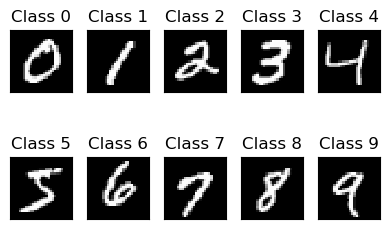

In [3]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train.shape', X_train.shape)

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)


X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

In [5]:
latent_dim = 100

generator = tf.keras.Sequential()
generator.add(
    tf.keras.layers.Dense(
        7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(tf.keras.layers.Reshape((7, 7, 256)))

generator.add(
    tf.keras.layers.Conv2DTranspose(
        128, 5, strides=1, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        64, 5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        1, 5, strides=2, padding="same", use_bias=False, activation="tanh"
    )
)


2023-11-01 22:54:56.352780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 22:54:56.367639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 22:54:56.367755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 22:54:56.368654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [6]:
# prints a summary representation of your model
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

#### Discriminator

In [7]:
discriminator = tf.keras.Sequential()
discriminator.add(
    tf.keras.layers.Conv2D(
        64, 5, strides=2, padding="same", input_shape=[28, 28, 1]
    )
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding="same"))
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))



#### Discriminator model visualization

In [8]:
# prints a summary representation of your model
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

### 3. Compile model

#### Compile discriminator

In [9]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [10]:
discriminator.trainable = False

z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = tf.keras.models.Model(inputs=z, outputs=decision)

d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


#### GAN model vizualization

In [11]:
# prints a summary representation of your model
d_g.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


### 4. Fit model

2023-11-01 22:54:56.873638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-11-01 22:54:56.926825: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 22:54:56.927230: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 22:54:56.927241: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-01 22:54:56.927831: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 22:54:56.927879: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-01 22:54:56.981309: I tensorflow/stream_executor/cuda/c

epoch = 1/100, d_loss=0.624, g_loss=0.863                                                                                                                      
1/1 [==============================] - 0s 134ms/step


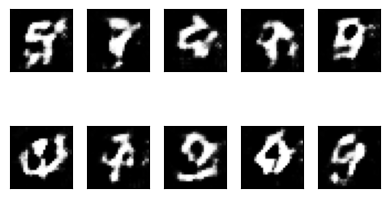

epoch = 2/100, d_loss=0.703, g_loss=0.838                                                                                                                      
epoch = 3/100, d_loss=0.641, g_loss=0.855                                                                                                                      
epoch = 4/100, d_loss=0.632, g_loss=0.915                                                                                                                      
epoch = 5/100, d_loss=0.616, g_loss=0.975                                                                                                                      
epoch = 6/100, d_loss=0.573, g_loss=0.987                                                                                                                      
epoch = 7/100, d_loss=0.571, g_loss=1.062                                                                                                                      
epoch = 8/100, d_loss=0.592, g_loss=1.00

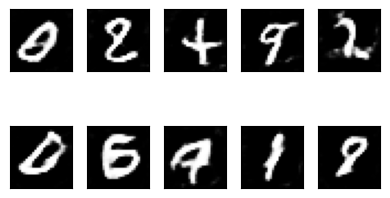

epoch = 12/100, d_loss=0.540, g_loss=1.118                                                                                                                      
epoch = 13/100, d_loss=0.612, g_loss=1.033                                                                                                                      
epoch = 14/100, d_loss=0.570, g_loss=1.054                                                                                                                      
epoch = 15/100, d_loss=0.549, g_loss=1.082                                                                                                                      
epoch = 16/100, d_loss=0.602, g_loss=1.048                                                                                                                      
epoch = 17/100, d_loss=0.582, g_loss=1.039                                                                                                                      
epoch = 18/100, d_loss=0.590, g_lo

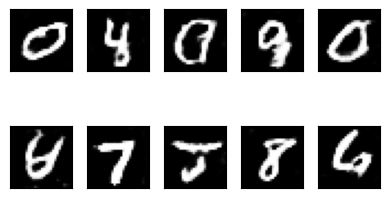

epoch = 22/100, d_loss=0.583, g_loss=1.076                                                                                                                      
epoch = 23/100, d_loss=0.585, g_loss=0.984                                                                                                                      
epoch = 24/100, d_loss=0.591, g_loss=0.992                                                                                                                      
epoch = 25/100, d_loss=0.585, g_loss=1.008                                                                                                                      
epoch = 26/100, d_loss=0.593, g_loss=1.015                                                                                                                      
epoch = 27/100, d_loss=0.631, g_loss=1.037                                                                                                                      
epoch = 28/100, d_loss=0.615, g_lo

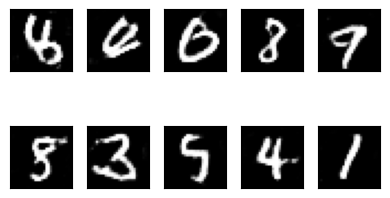

epoch = 32/100, d_loss=0.606, g_loss=1.063                                                                                                                      
epoch = 33/100, d_loss=0.631, g_loss=0.972                                                                                                                      
epoch = 34/100, d_loss=0.591, g_loss=1.078                                                                                                                      
epoch = 35/100, d_loss=0.633, g_loss=0.976                                                                                                                      
epoch = 36/100, d_loss=0.631, g_loss=0.978                                                                                                                      
epoch = 37/100, d_loss=0.633, g_loss=0.945                                                                                                                      
epoch = 38/100, d_loss=0.651, g_lo

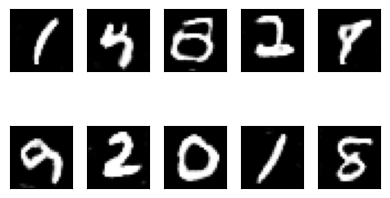

epoch = 42/100, d_loss=0.642, g_loss=0.938                                                                                                                      
epoch = 43/100, d_loss=0.666, g_loss=0.926                                                                                                                      
epoch = 44/100, d_loss=0.695, g_loss=0.929                                                                                                                      
epoch = 45/100, d_loss=0.654, g_loss=0.936                                                                                                                      
epoch = 46/100, d_loss=0.642, g_loss=1.020                                                                                                                      
epoch = 47/100, d_loss=0.615, g_loss=0.964                                                                                                                      
epoch = 48/100, d_loss=0.604, g_lo

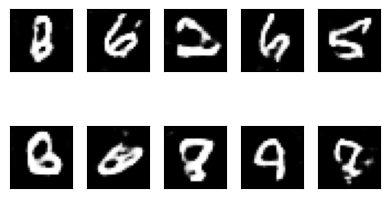

epoch = 52/100, d_loss=0.619, g_loss=1.031                                                                                                                      
epoch = 53/100, d_loss=0.627, g_loss=0.905                                                                                                                      
epoch = 54/100, d_loss=0.651, g_loss=0.923                                                                                                                      
epoch = 55/100, d_loss=0.677, g_loss=0.871                                                                                                                      
epoch = 56/100, d_loss=0.646, g_loss=1.001                                                                                                                      
epoch = 57/100, d_loss=0.633, g_loss=0.986                                                                                                                      
epoch = 58/100, d_loss=0.639, g_lo

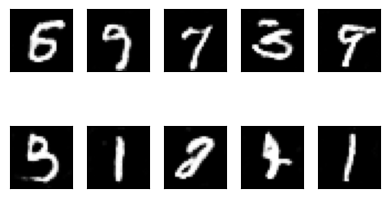

epoch = 62/100, d_loss=0.646, g_loss=0.946                                                                                                                      
epoch = 63/100, d_loss=0.691, g_loss=0.990                                                                                                                      
epoch = 64/100, d_loss=0.670, g_loss=0.959                                                                                                                      
epoch = 65/100, d_loss=0.696, g_loss=0.885                                                                                                                      
epoch = 66/100, d_loss=0.650, g_loss=0.920                                                                                                                      
epoch = 67/100, d_loss=0.720, g_loss=0.924                                                                                                                      
epoch = 68/100, d_loss=0.657, g_lo

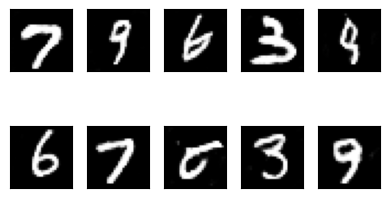

epoch = 72/100, d_loss=0.667, g_loss=0.960                                                                                                                      
epoch = 73/100, d_loss=0.678, g_loss=0.959                                                                                                                      
epoch = 74/100, d_loss=0.651, g_loss=0.924                                                                                                                      
epoch = 75/100, d_loss=0.676, g_loss=0.911                                                                                                                      
epoch = 76/100, d_loss=0.703, g_loss=0.860                                                                                                                      
epoch = 77/100, d_loss=0.672, g_loss=0.951                                                                                                                      
epoch = 78/100, d_loss=0.669, g_lo

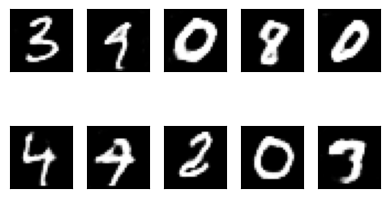

epoch = 82/100, d_loss=0.726, g_loss=0.848                                                                                                                      
epoch = 83/100, d_loss=0.679, g_loss=0.967                                                                                                                      
epoch = 84/100, d_loss=0.672, g_loss=0.910                                                                                                                      
epoch = 85/100, d_loss=0.664, g_loss=0.905                                                                                                                      
epoch = 86/100, d_loss=0.684, g_loss=0.922                                                                                                                      
epoch = 87/100, d_loss=0.634, g_loss=0.876                                                                                                                      
epoch = 88/100, d_loss=0.719, g_lo

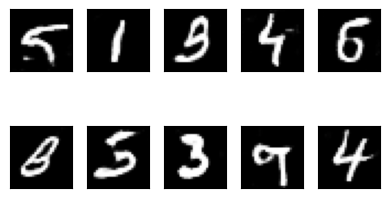

epoch = 92/100, d_loss=0.636, g_loss=0.932                                                                                                                      
epoch = 93/100, d_loss=0.697, g_loss=0.920                                                                                                                      
epoch = 94/100, d_loss=0.645, g_loss=0.919                                                                                                                      
epoch = 95/100, d_loss=0.708, g_loss=0.886                                                                                                                      
epoch = 96/100, d_loss=0.681, g_loss=0.901                                                                                                                      
epoch = 97/100, d_loss=0.734, g_loss=0.900                                                                                                                      
epoch = 98/100, d_loss=0.670, g_lo

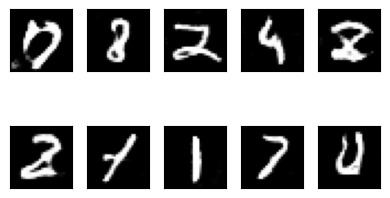

In [12]:
epochs = 100
batch_size = 64
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

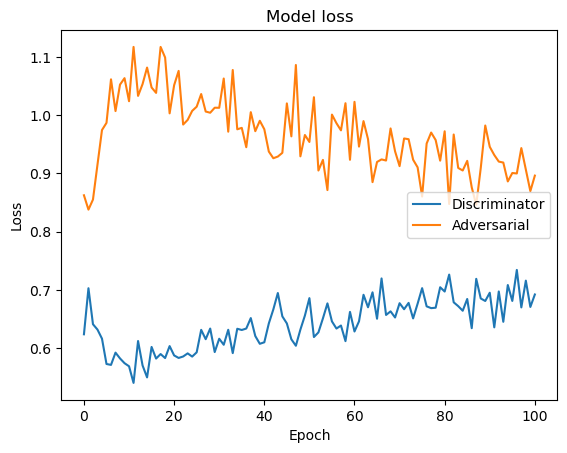

In [13]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()


## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)